In [2]:
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib as Path
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline


In [8]:
# btc_df = pd.read_csv(
#     Path("Julia/daily_btc_ohclv_2021.csv"), 
#     index_col = "Open Time")
# target_col = 'Close'
# btc_df = btc_df.drop(columns='Close Time')

In [17]:
btc_df = pd.read_csv("dailydata.csv",
                    index_col = "Open Time")
target_col = 'Close'

In [18]:
btc_df.head()

,Open,High,Low,Close,Volume
Open Time,,,,,
1/1/2021,28964.54,29680.00,28608.73,29407.93,1736.620480
1/2/2021,29393.99,33500.00,29027.03,32215.18,4227.234681
1/3/2021,32216.13,34851.30,32002.65,33033.26,3523.881120
1/4/2021,33040.00,33648.27,28000.00,32017.58,4218.572357
1/5/2021,32027.11,34498.00,29882.30,34059.70,3150.244271


In [19]:
btc_df.tail()

,Open,High,Low,Close,Volume
Open Time,,,,,
10/4/2021,48214.74,49507.80,46933.60,49247.63,1283.577550
10/5/2021,49252.59,51921.46,49057.36,51488.94,1382.533040
10/6/2021,51502.83,55794.07,50408.96,55330.92,2133.377701
10/7/2021,55332.46,55352.49,53392.38,53767.81,1434.183730
10/8/2021,53788.03,56150.90,53627.77,54291.11,1013.435345


In [ ]:
"""
Split the data into two sets -- training set and test set with 80% and 20% data respectively. 
"""

In [20]:
def train_test_split(btc_df, test_size=0.2):
  split_row = len(btc_df) - int(test_size * len(btc_df))
  train_data = btc_df.iloc[:split_row]
  test_data = btc_df.iloc[split_row:]
  return train_data, test_data

train, test = train_test_split(btc_df, test_size=0.2)

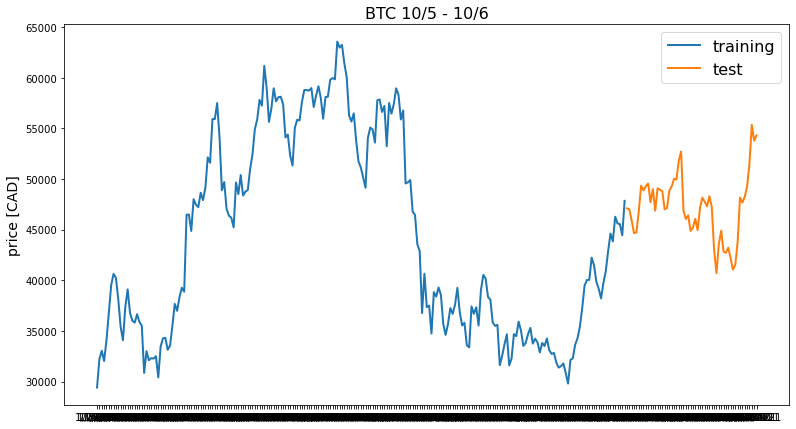

In [21]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [CAD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)

line_plot(train[target_col], test[target_col], 'training', 'test', title='BTC 10/5 - 10/6')

In [ ]:
""""
Normalize functions to prep data for RNN. Purpose is to change the values of
numeric columns in the dataset to a common scale, without distorting differences in 
the ranges of values.
"""

In [22]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [ ]:
"""
Extract data of windows which are of size of 5 each. SEE BELOW
"""

'\nExtract data of windows which are of size of 5 each. SEE BELOW\n'

In [23]:
def extract_window_data(btc_df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(btc_df) - window_len):
        tmp = btc_df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [ ]:
# Now prep the data in a format to be fed into the LSTM. Just splitting into two data sets
# Think we will need three datasets. This is a practice run.

In [24]:
def prepare_data(btc_df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(btc_df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [ ]:
"""
Building Sequential model for stacking all the layers(input, hidden, and output)
Compiled the model using Adam as the optimizer and Mean Squared Errir as the loss
function.
"""

'\nBuilding Sequential model for stacking all the layers(input, hidden, and output)\n'

In [25]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear', dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    return model

In [ ]:
"""
Set up parameters for later use. 
parameters -- random number seed, length of the window, test set size, 
number of neurons in LSTM layer, epochs, batch size, loss, dropouts, and optimizer
"""

'\nSet up parameters for later use. \nparameters -- random number seed, length of the window, test set size, \nnumber of neurons in LSTM layer, epochs, batch size, loss, dropouts, and optimizer\n'

In [26]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [ ]:
# train the model using inputs x_train and labels y_train

In [27]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    btc_df, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
7/7 [==============================] - 1s 4ms/step - loss: 0.0088
Epoch 2/20
7/7 [==============================] - 0s 3ms/step - loss: 0.0065
Epoch 3/20
7/7 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 4/20
7/7 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 5/20
7/7 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 6/20
7/7 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 7/20
7/7 [==============================] - 0s 3ms/step - loss: 0.0042
Epoch 8/20
7/7 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 9/20
7/7 [==============================] - 0s 3ms/step - loss: 0.0038
Epoch 10/20
7/7 [==============================] - 0s 3ms/step - loss: 0.0039
Epoch 11/20
7/7 [==============================] - 0s 3ms/step - loss: 0.0035
Epoch 12/20
7/7 [==============================] - 0s 3ms/step - loss: 0.0035
Epoch 13/20
7/7 [==============================] - 0s 3ms/step - loss: 0.

In [ ]:
# Used Mean Absolute Error as evaluation metric

In [28]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

0.03540851123176832

In [ ]:
# Plot the actual and predicted prices below

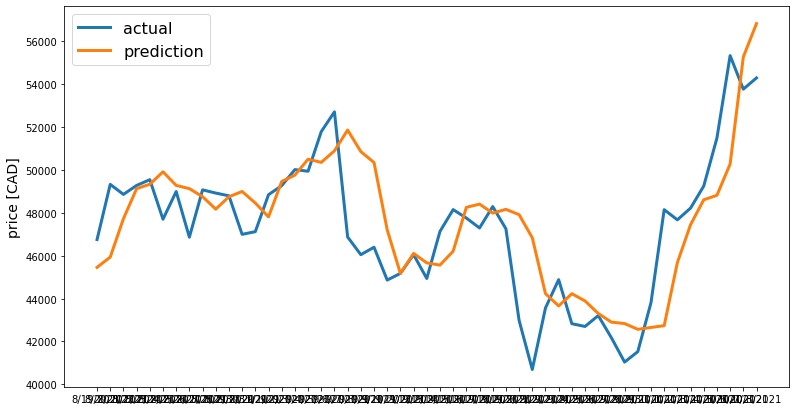

In [29]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)